## Urban Testbed Project - Infrastructure Placement

In [73]:
# load required packages
import networkx as nx
import osmnx as ox
import pandas as pd
import numpy as np
import folium
import geopy.distance
import random
from IPython.display import IFrame
ox.config(log_console=True, use_cache=True)

In [74]:
# import the graph
filepath = 'champaign_processed.graphml'
G = ox.load_graphml(filepath)
for i in G.nodes:
    Neighbour = list(G.neighbors(i))
    for item in Neighbour:
        route = nx.shortest_path_length(G,i,item,weight = 'length')
        if route <=10 and G.nodes[i]['pop_score_block'] != -1:
            G.nodes[item]['pop_score_block'] = -1
 #change data types of some attributes
DePop = []
for i in G.nodes:
    if G.nodes[i]['pop_score_block'] == -1:
        G.nodes[i]['pop_score_block'] = 0
        DePop.append(i)
for _,data in G.nodes(data=True):
    data['pop_score_tract'] = float(data['pop_score_tract'])
    data['pop_score_block'] = float(data['pop_score_block'])    

### Algorithms - Implementation and Visualization

In [75]:
nx.is_strongly_connected(G) 

True

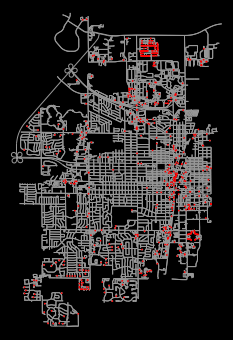

In [95]:
nc = ['r' if node in DePop else 'w' for node in G.nodes()]
ns = [3 if node in DePop else 0 for node in G.nodes()]
fig, ax = ox.plot_graph(G, node_size=ns, node_color=nc, node_zorder=2, bgcolor='k')

In [77]:
# create a dictionary for all possible routs
node_ID = list(G.nodes())
path_lengths = dict(nx.all_pairs_dijkstra_path_length(G, weight='distance')) 


In [78]:
# initialize by placing all facilities in the node with highest centriality
extended_stats = ox.extended_stats(G, ecc=False, bc=True, cc=False)
startN,dump = max(extended_stats['betweenness_centrality'].items(), key=lambda x: x[1])
# start with all facility at startN
# initialize a few parameters before running
facility = [startN * item for item in [1,1,1,1,1]]
score_old = 0

In [86]:
# or start with some random input
facility = []
for k in range(5):
    facility.append(random.choice(node_ID))
facility


[5428059287, 4470454133, 5817947482, 7025285172, 2280221381]

In [87]:
# Now compute the original score 
for i in node_ID:
    path = min([path_lengths[j][i] for j in facility])
    score_old = score_old+path*G.nodes[i]['pop_score_block']
score_old

18091.631180625678

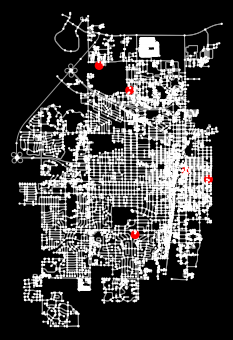

In [88]:
# visualize initial input
nc = ['r' if node in facility else 'w' for node in G.nodes()]
ns = [80 if node in facility else 5 for node in G.nodes()]
fig, ax = ox.plot_graph(G, node_size=ns, node_color=nc, node_zorder=2, bgcolor='k')

In [94]:
# loop through each facility, until there is no better score 
score_new = score_old-1
count = 0
while score_new < score_old:
    score_old = score_new
    count += 1
    for i in range(5):
        score_new = 0
        neigh = list(G.neighbors(facility[i]))
        temp = facility
        TEMP_SCORE = []
        for item in neigh:
            temp_score = 0
            temp[i] = item
            for j in node_ID:
                path = min([path_lengths[t][j] for t in temp])
                temp_score = temp_score+path*G.nodes[j]['pop_score_block']
            TEMP_SCORE.append(temp_score)
        score_new = min(TEMP_SCORE)
        step_dir = neigh[TEMP_SCORE.index(score_new)]
        facility[i] = step_dir
print(score_new)
print(count)
# Actual location of facilities
print(facility)

7845.3549445005
1
[38089220, 38086813, 38035941, 1520427840, 38146585]


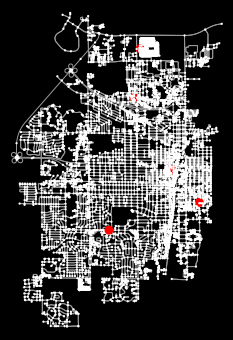

In [91]:
# Visualization of the result
nc = ['r' if node in facility else 'w' for node in G.nodes()]
ns = [80 if node in facility else 5 for node in G.nodes()]
fig, ax = ox.plot_graph(G, node_size=ns, node_color=nc, node_zorder=2, bgcolor='k')